In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit
from matplotlib.cm import ScalarMappable

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
mu_0 = sp.constants.mu_0
hbar = sp.constants.hbar
h = sp.constants.h
g = sp.constants.g
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]
inch = 25.4e-3

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [56]:
numm = 4
M = 1.2 #in T (also known as remanance)
V = 10*25*3e-9 #in m3, volume of magnet stack
m = numm*M*V*np.array([[0, 0, 1], [0, 0, -1],[0, 0, 1], [0, 0, -1]])/mu_0 #magnetic moment of the magnet
a = 1.5*inch
ax = 1.5*inch
posm = np.array([[ax, a, 0], [ax, -a, 0], [-ax, a, 0], [-ax, -a, 0]]) #position of the magents

In [57]:
def Bfield(r):
    b = 0
    for i, mi in enumerate(m):
        dist = np.sqrt(np.sum(np.square(r-posm[i])))
        b += mu_0/4/np.pi * (3*(r-posm[i])*np.dot(mi, r-posm[i])/dist**5 - mi/dist**3)
    return b

# Bfield with 4 magnet stacks:

In [58]:
y = np.linspace(-1*inch, 1*inch, 15)
z = np.linspace(-1*inch, 1*inch, 15)

rb = np.array([[np.array([0,yy,zz]) for yy in y] for zz in z])

B = np.array([[Bfield(rb[j][i]) for i in range(len(y))] for j in range(len(z))]).transpose()
Bx = B[:,:][0]
By = B[:,:][1]
Bz = B[:,:][2]
Bmag = np.sqrt(By**2+Bz**2+Bx**2)

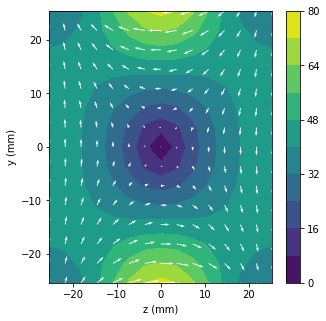

In [59]:
plt.figure(figsize=(5,5))
plot = plt.contourf(z*1e3, y*1e3, Bmag*1e4, extent=[y[0],y[-1],z[0],z[-1]], origin='lower', levels=10)
plt.quiver(z*1e3, y*1e3, Bz, By, color='white')
plt.xlabel('z (mm)')
plt.ylabel('y (mm)')
plt.colorbar(plot)

In [60]:
def line(x, a, b):
    return a*(x)+b

gradient: -28.667200082771537 G/cm


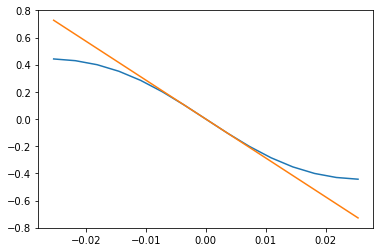

In [61]:
popt, pcov = curve_fit(line, y[6:-6], By[8,:][6:-6]*1e4/1e2)
plt.plot(y, By[8,:]*1e4/1e2)
plt.plot(y, line(y, *popt))
print('gradient:', popt[0], 'G/cm')

In [62]:
y = np.linspace(-0.3*inch, 0.3*inch, 15)
x = np.linspace(-0.3*inch, 0.3*inch, 15)

rb = np.array([[np.array([xx,yy,0]) for yy in y] for xx in x])

B = np.array([[Bfield(rb[j][i]) for i in range(len(y))] for j in range(len(x))]).transpose()
By = B[:,:][1]
Bx = B[:,:][0]
Bz = B[:,:][2]
Bmag = np.sqrt(By**2+Bx**2+Bz**2)

C:\Users\klab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\klab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


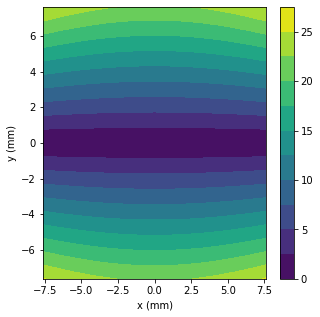

In [63]:
plt.figure(figsize=(5,5))
plot=plt.contourf(x*1e3, y*1e3, Bmag*1e4, extent=[y[0],y[-1],x[0],x[-1]], origin='lower', levels=10)
plt.quiver(x*1e3, y*1e3, Bx, By, color='white')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar(plot)

# Monte Carlo

https://arxiv.org/abs/physics/0103085v1

In [10]:
_lambda = 399e-9
k = 2*np.pi/_lambda
Isat = 60e-3*1e4 #W/m2
Gamma = 30e6
w = 10e-3
P = 150e-3
I0 = 2*P/np.pi/w**2
m171 = 171*u
Delta = -2*Gamma
dt = 1e-5

gravity = g*np.array([0,-1,0])

In [67]:
def Zeeman_shift(dmF, r):

    B = np.sqrt(np.sum(np.square(Bfield(r))))
    
    L = 1
    S = 0
    J = 1
    I = 1/2
    F = 3/2

    gJ = 3/2 + (S*(S+1) - L*(L+1)) / 2 / J / (J+1)  
    gF = (F*(F+1) + J*(J+1) - I*(I+1)) / 2 / F / (F+1) * gJ

    return mB*gF*B*dmF/hbar

In [68]:
def epsilon(k, q):
    knorm = k/np.linalg.norm(k)
    ihat = x
    jhat = knorm
    khat = np.cross(ihat, jhat)
    
    if q==1:
        return -1/np.sqrt(2)*(z+1j*ihat)
    elif q==0:
        return jhat
    elif q==-1:
        return 1/np.sqrt(2)*(z-1j*ihat)

def rotation_matrix(k, r, pol):
    knorm = k/np.linalg.norm(k)
    B = Bfield(r)
    Bnorm = B/np.linalg.norm(B)
    cos = np.dot(knorm, Bnorm)
    sin = np.sqrt(1-cos**2)
    
    Mq = 1/2* np.array( [[1+cos, -np.sqrt(2)*sin, 1-cos], 
                           [np.sqrt(2)*sin, 2*cos, -np.sqrt(2)*sin], 
                           [1-cos, np.sqrt(2)*sin, 1+cos] ]  )
    
    return np.matmul(Mq,pol)

In [107]:
def force2Dmot(r, v):
    '''force from a laser beam i via transition j (delta m == -j)'''
    
    f = 0
    stot = []
    Rtot = []
    
    for i in range(4):
        
        si = []
    
        for j in [1, 0, -1]:
            if j == 1:
                idx = 0
            elif j == 0:
                idx = 1
            elif j == -1:
                idx = 2

            Wj = np.abs(rotation_matrix(ki[i], r, poli[i])[idx])**2
            
            dist = np.sqrt(np.sum( np.abs(np.cross(r, ki[i]/k))**2))
            Ii = I0*np.exp( -2*dist**2/w**2 )
            sij = Ii* Wj/Isat        
            
            si.append(sij)
            
        stot.append(si)

    for i in range(4):
        
        si = stot[i]
        Ri = 0
        
        for idx,j in enumerate([1, 0, -1]):
            dmF = -j
            deltaij = Delta - np.dot(ki[i], v) - Zeeman_shift(dmF, r)
            sij = si[idx]
            Rij = Gamma/2 * sij/(1+np.sum(stot)+4*(deltaij/Gamma)**2)
            Ri = Ri+Rij
        
        Rtot.append(Ri)
  
        fi = hbar*ki[i]*Ri
    
         #add random scattering force
        kscatt = np.array([np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)])
        kscatt = kscatt/np.linalg.norm(kscatt)
        fr = hbar*k*kscatt*np.sqrt(Rtot[i]/dt)
        
        f = f + fi + fr
        
    return f + gravity*m171

In [108]:
def RK4(xn, vn, f):
    
    h = dt

    k1x = vn
    k1v = f(xn, vn)/m171
    
    k2x = vn + k1v*h/2
    k2v = f(xn + k1x*h/2, vn + k1v*h/2)/m171
    
    k3x = vn + k2v*h/2
    k3v = f(xn + k2x*h/2, vn + k2v*h/2)/m171
    
    k4x = vn + k3v*h
    k4v = f(xn + k3x*h, vn + k3v*h)/m171
    
    vn1 = vn + (k1v + 2*k2v + 2*k3v + k4v)*(h/6)
    xn1 = xn + (k1x + 2*k2x + 2*k3x + k4x)*(h/6)

    return xn1, vn1, f(xn, vn)

In [109]:
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

ki = k*np.array( [ -y+z, -y-z, y+z, y-z]) #, -y+z, -y-z wavevectors of the mot beams
poli = np.array( [ epsilon(ki[0], 1), epsilon(ki[1], -1), epsilon(ki[2], -1), epsilon(ki[3], 1)]) #

In [110]:
r0 = np.array([0.,-15e-3, 0.])
v0 = np.array([0., 10, 0])


pos_array = []
vel_array = []
f_array = []
count_array = []

r = r0
v = v0
a = gravity

count = 0
tot_count = 500
while count<tot_count:
    r, v, f = RK4(r, v, force2Dmot)
    pos_array.append(r)
    vel_array.append(v)
    count_array.append(count)
    f_array.append(f)
    count = count+1
    
pos_array = np.real(np.array(pos_array) )
vel_array = np.real(np.array(vel_array) )
count_array = np.array(count_array)
f_array = np.array(f_array)

In [111]:
r

array([0.0259075 , 0.00254264, 0.00540205])

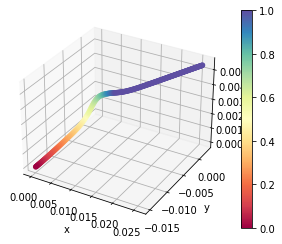

In [112]:
ax = plt.figure().add_subplot(projection='3d')

# Prepare arrays x, y, z
zplot = pos_array[:,2]
xplot = pos_array[:,0]
yplot = pos_array[:,1]

cmap = plt.get_cmap("Spectral")
sm =  ScalarMappable(cmap=cmap)
sm.set_array([])
ax.scatter(xplot, yplot, zplot, c=cmap(count_array))

plt.xlabel('x')
plt.ylabel('y')

cbar = plt.colorbar(sm, ax=ax)
plt.show()


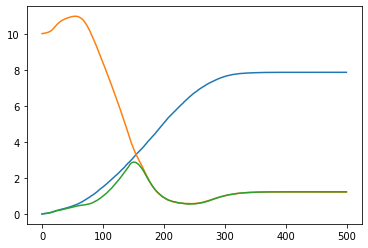

In [113]:
plt.plot(vel_array)

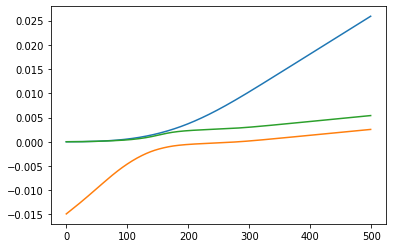

In [114]:
plt.plot(pos_array)

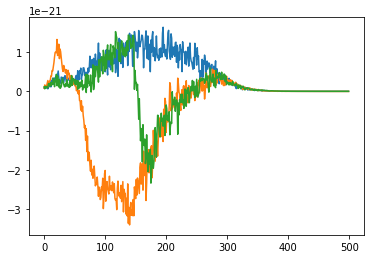

In [115]:
plt.plot(f_array)

In [116]:
from tqdm import tqdm

T = 450 + 273.15
trapped = 0
pos_tot = []
for N in tqdm(range(100)):

    r0 = np.array([0.,-15e-3, 0.])
    v_std = np.sqrt(kB*T/m171)
    vx0 = 0#np.random.normal(0, v_std, 1)[0]
    vy0 = np.random.normal(10, 5, 1)[0]
    vz0 = 0 #np.random.normal(0, v_std, 1)[0]
    v0 = np.array([vx0, vy0, vz0])


    pos_array = []

    r = r0
    v = v0

    count = 0
    tot_count = 500
    while count<tot_count:
        r, v, f = RK4(r, v, force2Dmot)
        pos_array.append(r)
        count = count+1
        
    if w > np.sqrt(r[1]**2+r[2]**2):
        trapped = trapped+1
        
    pos_tot.append(pos_array)
        
pos_tot=np.array(pos_tot)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:45<00:00,  5.25s/it]


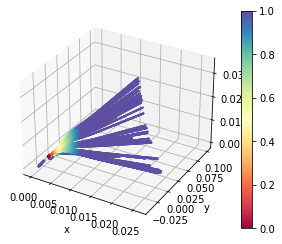

In [117]:
ax = plt.figure().add_subplot(projection='3d')

for pos_array in pos_tot:
# Prepare arrays x, y, z
    zplot = pos_array[:,2]
    xplot = pos_array[:,0]
    yplot = pos_array[:,1]

    cmap = plt.get_cmap("Spectral")
    sm =  ScalarMappable(cmap=cmap)
    sm.set_array([])
    ax.scatter(xplot, yplot, zplot,  c=cmap(count_array), s=1)

plt.xlabel('x')
plt.ylabel('y')

cbar = plt.colorbar(sm, ax=ax)
plt.show()


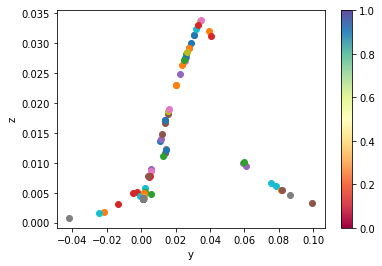

In [123]:
fig, ax = plt.subplots()

for pos_array in pos_tot:
# Prepare arrays x, y, z
    zplot = pos_array[:,2]
    xplot = pos_array[:,0]
    yplot = pos_array[:,1]

    cmap = plt.get_cmap("Spectral")
    sm =  ScalarMappable(cmap=cmap)
    sm.set_array([])
    ax.scatter(yplot[-1], zplot[-1])

plt.xlabel('y')
plt.ylabel('z')

cbar = plt.colorbar(sm, ax=ax)
plt.show()


In [120]:
trapped/100

0.5